In [1]:
import typing as t

import numpy as np 
import matplotlib.pyplot as plt 
from scipy.ndimage.filters import convolve

# add src to path
sys.path.append('../..')
from utils.db_helper import get_image_data

In [2]:
SOURCE_DIR_V1 = "C:/database/StyleGanv1"
SOURCE_DIR_V2 = "C:/database/StyleGanv2"
SOURCE_DIR_FFHQ = "C:/database/FFHQ"

In [3]:
ffhq_datagen = get_image_data(SOURCE_DIR_FFHQ, type = 'int')

In [4]:
def calculate_difference_image(np_img: np.ndarray)-> np.ndarray:
    """
    np_img must be int not float
    """
    np_filter = np.array((1,-1)).reshape(1,2)
    np_img = np_img.astype(np.int16)
    np_diff_img = np.empty(np_img.shape, dtype=np.int16)
    if len(np_img.shape) == 3:
        for i in range(np_img.shape[-1]):
            np_diff_img[:,:,i] = convolve(np_img[:,:,i], np_filter)
    elif len(np_img.shape) == 2:
        np_diff_img = convolve(np_img, np_filter)
    else:
        raise ValueError('Bad shape of the image')
    return np_diff_img

In [5]:
def hist_peek_point(img: np.ndarray, bins=511, hist_range=(-255,256))-> t.Tuple[float, int]:
    hist, bins = np.histogram(img, density=True, bins=bins, range=hist_range)
    y = hist.max()
    idx = int(np.argwhere(hist==y))
    x = int(bins[idx])
    return x, y

In [6]:
def avg_hist_from_diff_img(src_path: str, max_number_of_images=10, bins=511)-> t.Tuple[np.ndarray, range]:
    print("Loading dataset...")
    hist_range = (-255,256)  #ToDo automatic generation based on bins
    dataset_gen = get_image_data(src_path, type='int')
    print("Processing database...")
    number_of_images = 0
    np_avg_hist = np.zeros((bins,), dtype=np.float64)
    for img in dataset_gen:
        diff_img = calculate_difference_image(img)
        hist, _ = np.histogram(diff_img, density=True, bins=bins, range=hist_range)
        np_avg_hist += hist
        number_of_images += 1
        if np_avg_hist.max() > 0.95*np.finfo(np_avg_hist.dtype).max:
            raise ValueError("Dataset to large")
            break
        elif number_of_images == max_number_of_images:
            print("Finish calcluating avg histogram")
            break
    return np_avg_hist / number_of_images, range(hist_range[0], hist_range[1])


In [7]:
def peek_points_from_diff_dataset(src_path: str, bins=511, max_number_of_images=10)-> t.Tuple[t.List[float], t.List[int]]:
    print("Loading dataset...")
    dataset_gen = get_image_data(src_path, type='int', max_number_of_images=max_number_of_images)
    print("Processing database...")
    peek_points_x, peek_points_y = [], []
    for img in dataset_gen:
        diff_img = calculate_difference_image(img)
        x, y = hist_peek_point(diff_img)
        peek_points_x.append(x)
        peek_points_y.append(y)
    return peek_points_x, peek_points_y

In [33]:
_, FFHQ_peek_points = peek_points_from_diff_dataset(SOURCE_DIR_FFHQ, max_number_of_images=1000)
_, Stylev1_peek_points = peek_points_from_diff_dataset(SOURCE_DIR_V1, max_number_of_images=1000)
_, Stylev2_peek_points = peek_points_from_diff_dataset(SOURCE_DIR_V2, max_number_of_images=1000)

Loading dataset...
Processing database...
len: 1000
Loading dataset...
Processing database...
len: 1000
Loading dataset...
Processing database...
len: 1000


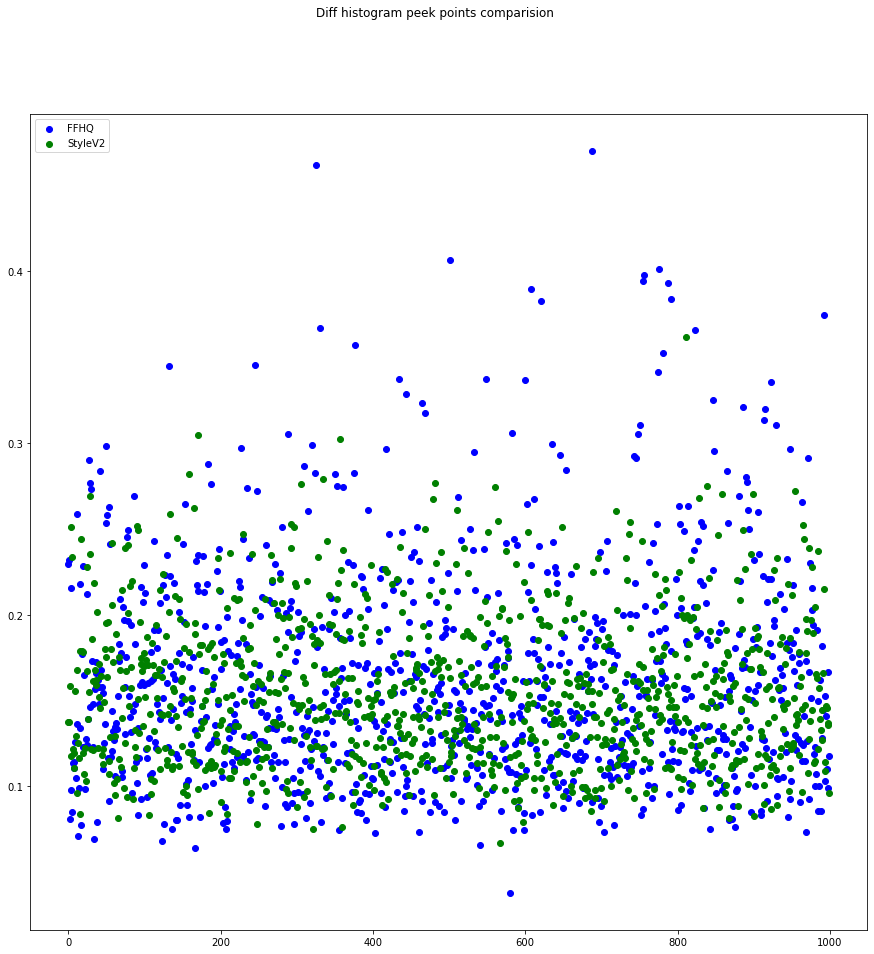

In [43]:
x = len(FFHQ_peek_points)
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(111)

ax1.scatter(range(x), FFHQ_peek_points, color='blue', label='FFHQ')
#ax1.scatter(range(x), Stylev1_peek_points, color='orange', label='StyleV1')
ax1.scatter(range(x), Stylev2_peek_points,  color='green', label='StyleV2')
fig.suptitle('Diff histogram peek points comparision')
plt.legend(loc='upper left')
plt.show()
fig.savefig('../../../exp/Histograms/Peek_points_comparision_v2.png')

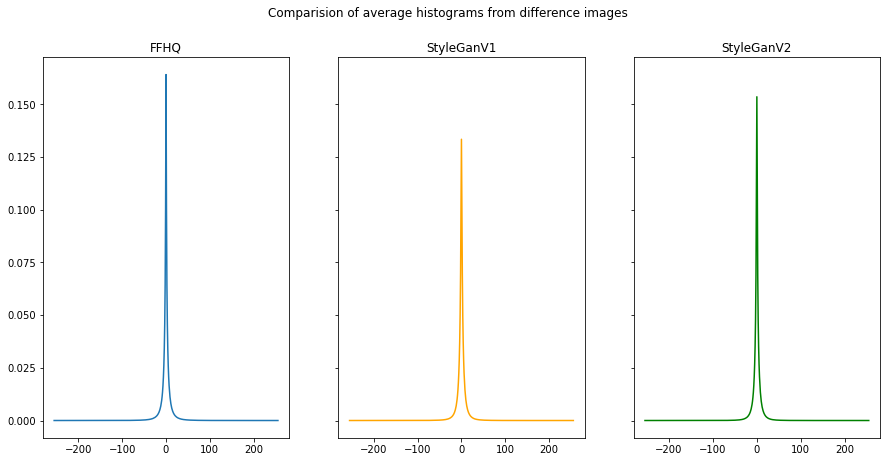

In [96]:
# np_ffhq_avg_hist, bins = avg_hist_from_diff_img(SOURCE_DIR_FFHQ, max_number_of_images=1000)
# np_style1_avg_hist, bins = avg_hist_from_diff_img(SOURCE_DIR_V1, max_number_of_images=1000)
# np_style2_avg_hist, bins = avg_hist_from_diff_img(SOURCE_DIR_V2, max_number_of_images=1000)

# fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15,7))
# fig.suptitle('Comparision of average histograms from difference images')
# axs[0].plot(list(bins), np_ffhq_avg_hist)
# axs[0].set_title('FFHQ')
# axs[1].plot(list(bins), np_style1_avg_hist, color="orange")
# axs[1].set_title('StyleGanV1')
# axs[2].plot(list(bins), np_style2_avg_hist, color="green")
# axs[2].set_title('StyleGanV2')
#fig.savefig('../../../exp/Histograms/Avg_comparision.png')